# Genome Assembly workbook - Mayo-Illinois Course 2024

## Test the environment

We need the following modules preloaded before we start this notebook! 

* seqkit/2.6.1
* hifiasm/0.19.6-IGB-gcc-8.2.0
* Bandage/0.8.1
* gfatools/0.5-IGB-gcc-8.2.0

We test this with the following cell, which should print a help menu, which we can then collapse.  

If it doesn't work and there is a bash kernel showing in the top right corner, you will need to shut the kernel down, load the modules using the 'Softwares' tab on the left tab, and then restart the kernel and rerun the command below

In [1]:
seqkit -h

SeqKit -- a cross-platform and ultrafast toolkit for FASTA/Q file manipulation

Version: 2.6.1

Author: Wei Shen <shenwei356@gmail.com>

Documents  : http://bioinf.shenwei.me/seqkit
Source code: https://github.com/shenwei356/seqkit
Please cite: https://doi.org/10.1371/journal.pone.0163962


Seqkit utlizies the pgzip (https://github.com/klauspost/pgzip) package to
read and write gzip file, and the outputted gzip file would be slighty
larger than files generated by GNU gzip.

Seqkit writes gzip files very fast, much faster than the multi-threaded pigz,
therefore there's no need to pipe the result to gzip/pigz.

Seqkit also supports reading and writing xz (.xz) and zstd (.zst) formats since v2.2.0.
Bzip2 format is supported since v2.4.0.

Compression level:
  format   range   default  comment
  gzip     1-9     5        https://github.com/klauspost/pgzip sets 5 as the default value.
  xz       NA      NA       https://github.com/ulikunitz/xz does not support.
  zstd     1-4     2        r

## Copy over the data

In [8]:
cp -r /home/classroom/mayo/2024/Genome-Assembly/data/* . 

## Run seqkit stats on the raw sequence data

Let's check how much data we current have in the four different data sets.

In [1]:
seqkit stats --quiet dataset*.fastq.gz 

file               format  type  num_seqs     sum_len  min_len   avg_len  max_len
dataset1.fastq.gz  FASTQ   DNA      7,286  75,079,593      793  10,304.6   28,055
dataset2.fastq.gz  FASTQ   DNA      3,611  37,452,304      793  10,371.7   27,426
dataset3.fastq.gz  FASTQ   DNA      1,800  18,723,557      793    10,402   27,426
dataset4.fastq.gz  FASTQ   DNA        724   7,471,070    1,010  10,319.2   25,180


The overall stats above should indicate how much genome coverage there is per sample.  The genome size is about 1.7Mb.  We try to aim for 20-30x minimum, though we can assemble lower coverage with some caveats (as you'll see).

We want to keep a record of the data, so let's rerun the above but use the `-T` option (fo creating tab-delimited output) and redirect the output to a file.  Notice that `.tsv` (tab-delimited) files in the left-side file browser can be opened by double-clicking into a table format, which can be pretty handy.

In [2]:
seqkit stats -T --quiet dataset*.fastq.gz > seqkit-reads.tsv

## Run assembly 1

Now we are going to run our assemblies.  The first will take about 7-8 minutes, maybe more if everyone is running these all at once ;)

In [4]:
mkdir -p dataset1
time hifiasm -o dataset1/full.asm --n-hap 1 -l0 -t $SLURM_NTASKS dataset1.fastq.gz 2> dataset1/full.log


real	7m5.678s
user	7m42.467s
sys	0m29.526s


## Run assembly 2

Assembly 2 has half the coverage of the first.

In [9]:
mkdir -p dataset2
time hifiasm -o dataset2/half.asm --n-hap 1 -l0 -t $SLURM_NTASKS dataset2.fastq.gz 2> dataset2/half.log


real	2m52.234s
user	2m11.221s
sys	0m24.658s


## Run assembly 3

Assembly 3 has 1/4 the coverage of the first.

In [7]:
mkdir -p dataset3
time hifiasm -o dataset3/quarter.asm --n-hap 1 -l0 -t $SLURM_NTASKS dataset3.fastq.gz 2> dataset3/quarter.log


real	1m42.339s
user	0m45.192s
sys	0m21.649s


## Run assembly 4

Assembly 4 has 1/10 the coverage of the first, so the overall coverage is pretty sparse.

In [8]:
mkdir -p dataset4
time hifiasm -o dataset4/sparse.asm --n-hap 1 -l0 -t $SLURM_NTASKS dataset4.fastq.gz 2> dataset4/sparse.log


real	1m15.638s
user	0m13.432s
sys	0m18.429s


## Summary of the above assemblies

Any obvious pattern from the times the assemblies took?

## Convert sequence formats

We commonly need to convert from one bioinformatics format to another.  In this case, hifiasm produces GFA files, which are useful but isn't a format that most downstream tools use, which is a simpler format called FASTA.  Here, we do a simple conversion of the primary contig files from GFA to FASTA using a tool called `gfatools` (appropriately enought). Some of these tools are multiuse and have subcommands; in this case the subcommand to convert from GFA to FASTA is `gfa3fa`.

In [10]:
gfatools gfa2fa dataset1/full.asm.bp.p_ctg.gfa > dataset1/full.asm.bp.p_ctg.fasta
gfatools gfa2fa dataset2/half.asm.bp.p_ctg.gfa > dataset2/half.asm.bp.p_ctg.fasta
gfatools gfa2fa dataset3/quarter.asm.bp.p_ctg.gfa > dataset3/quarter.asm.bp.p_ctg.fasta
gfatools gfa2fa dataset4/sparse.asm.bp.p_ctg.gfa > dataset3/sparse.asm.bp.p_ctg.fasta

[M::main] Version: 0.4-r214-dirty
[M::main] CMD: gfatools gfa2fa dataset1/full.asm.bp.p_ctg.gfa
[M::main] Real time: 0.019 sec; CPU: 0.031 sec
[M::main] Version: 0.4-r214-dirty
[M::main] CMD: gfatools gfa2fa dataset2/half.asm.bp.p_ctg.gfa
[M::main] Real time: 0.020 sec; CPU: 0.026 sec
[M::main] Version: 0.4-r214-dirty
[M::main] CMD: gfatools gfa2fa dataset3/quarter.asm.bp.p_ctg.gfa
[M::main] Real time: 0.016 sec; CPU: 0.023 sec
[M::main] Version: 0.4-r214-dirty
[M::main] CMD: gfatools gfa2fa dataset4/sparse.asm.bp.p_ctg.gfa
[M::main] Real time: 0.014 sec; CPU: 0.020 sec


In [12]:
ls -l dataset*/*.fasta

-rw-rw-r-- 1 class05 class05 1673205 Jun  3 22:21 dataset1/full.asm.bp.p_ctg.fasta
-rw-rw-r-- 1 class05 class05 1673072 Jun  3 22:21 dataset2/half.asm.bp.p_ctg.fasta
-rw-rw-r-- 1 class05 class05 1683860 Jun  3 22:21 dataset3/quarter.asm.bp.p_ctg.fasta
-rw-rw-r-- 1 class05 class05 1417890 Jun  3 22:21 dataset3/sparse.asm.bp.p_ctg.fasta


## Generate assembly stats

Now we want to see some stats for the sequences.  Here we can use `seqkit` again, but we also want the N50 value.  We can get this using `seqkit stats` by requesting full stats.  Let's first save it to a file (the extended stats make the raw output hard to read).

In [13]:
seqkit stats -T --quiet -a dataset*/*.fasta > seqkit-assembly.stats.tsv

Now we can open this file separately.  In the file browser, double-click to open the file.

## Visualize data using Bandage

We can visualize the assemblies using the tool Bandage.  We have an optional section in the lab for using Bandage using the GUI, but you can also use Bandage for generating simple graphs of the assemblies.  Let's look at the first one (dataset1).  

The following command will generate a PNG file

In [14]:
Bandage image dataset1/full.asm.bp.p_ctg.noseq.gfa dataset1/full.png

This command can then have the image (PNG or JPEG) displayed in the notebook:

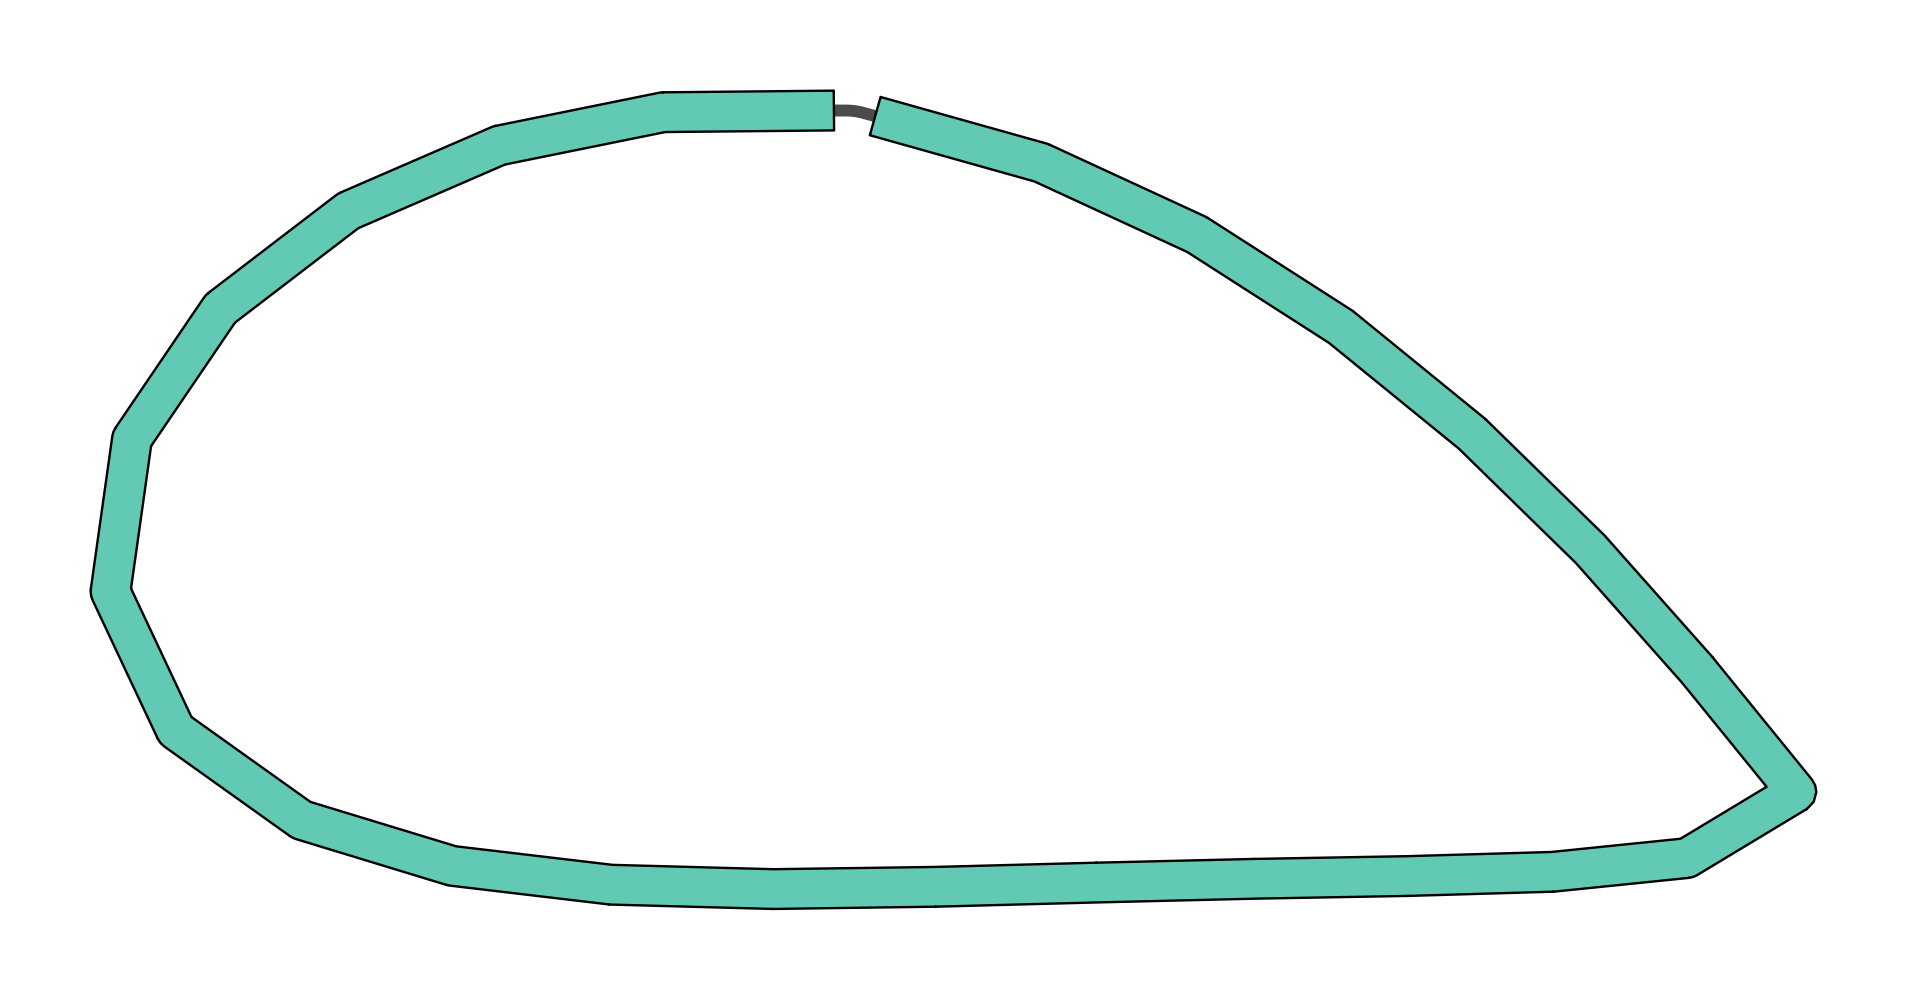

In [15]:
cat dataset1/full.png | display

This should be a closed circular genome (hopefully this is what you get.

We can now look at the other assemblies.  For dataset2 ('half'):

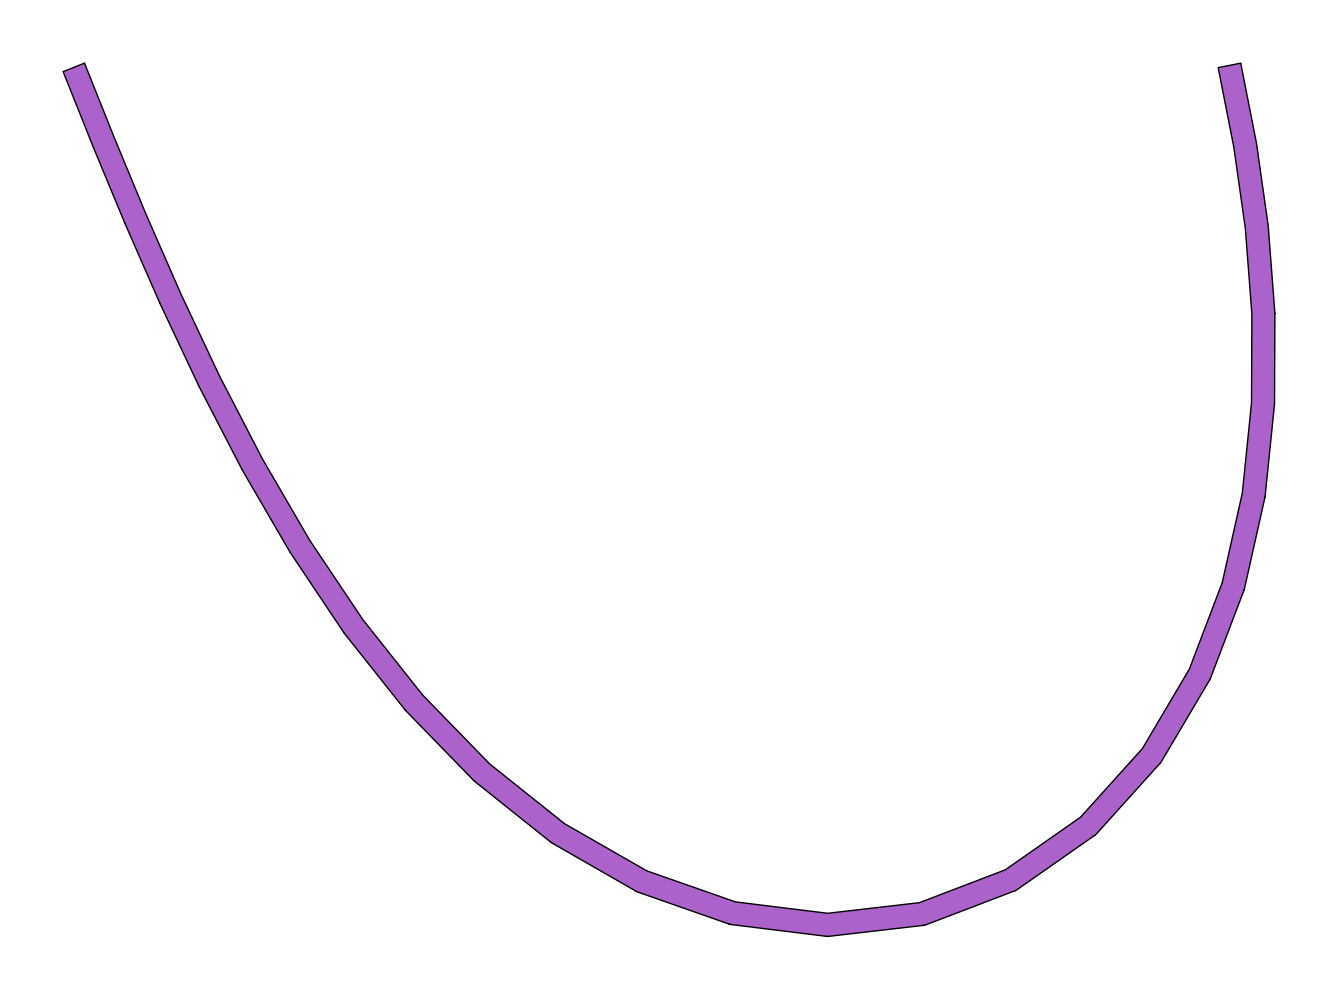

In [1]:
Bandage image dataset2/half.asm.bp.p_ctg.noseq.gfa dataset2/half.png
cat dataset2/half.png | display

Not quite closed, but one contig. Not too bad!

And now for dataset3 ('sparse').  

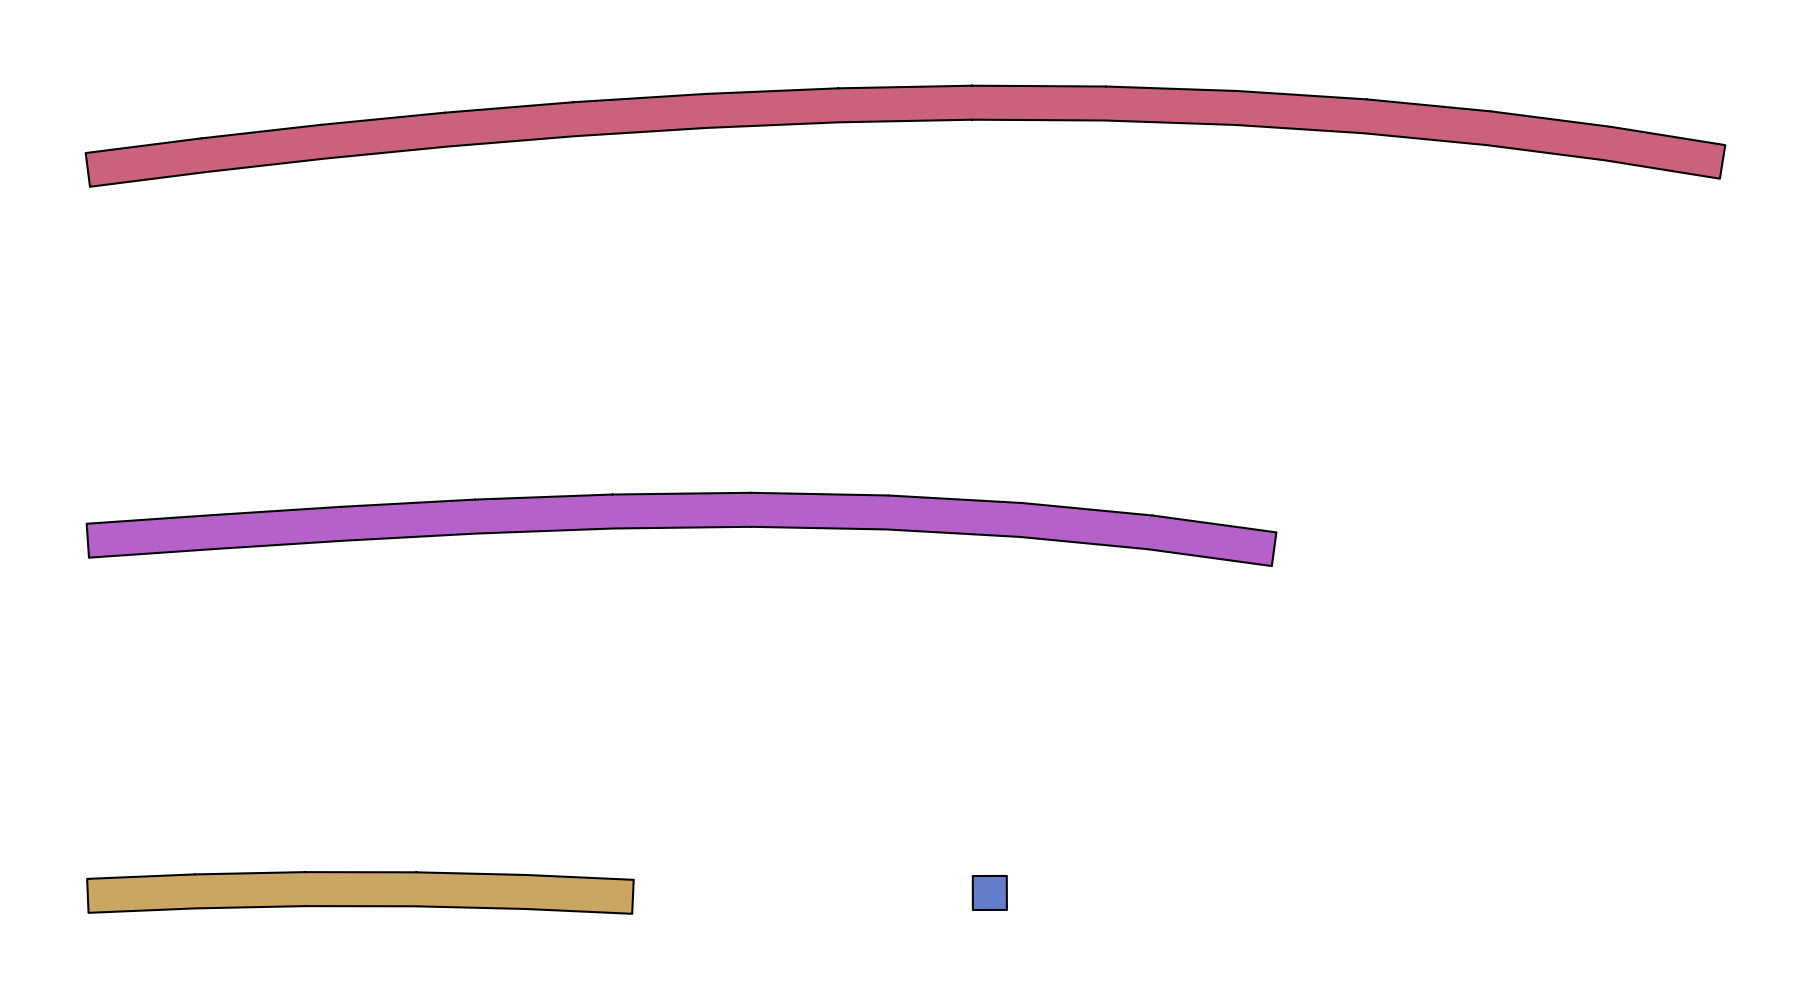

In [2]:
Bandage image dataset3/quarter.asm.bp.p_ctg.noseq.gfa dataset3/quarter.png
cat dataset3/quarter.png | display

A bit more fragmented; we're starting to see effects of lower genome coverage.  And now for the worst one, assembly 4:

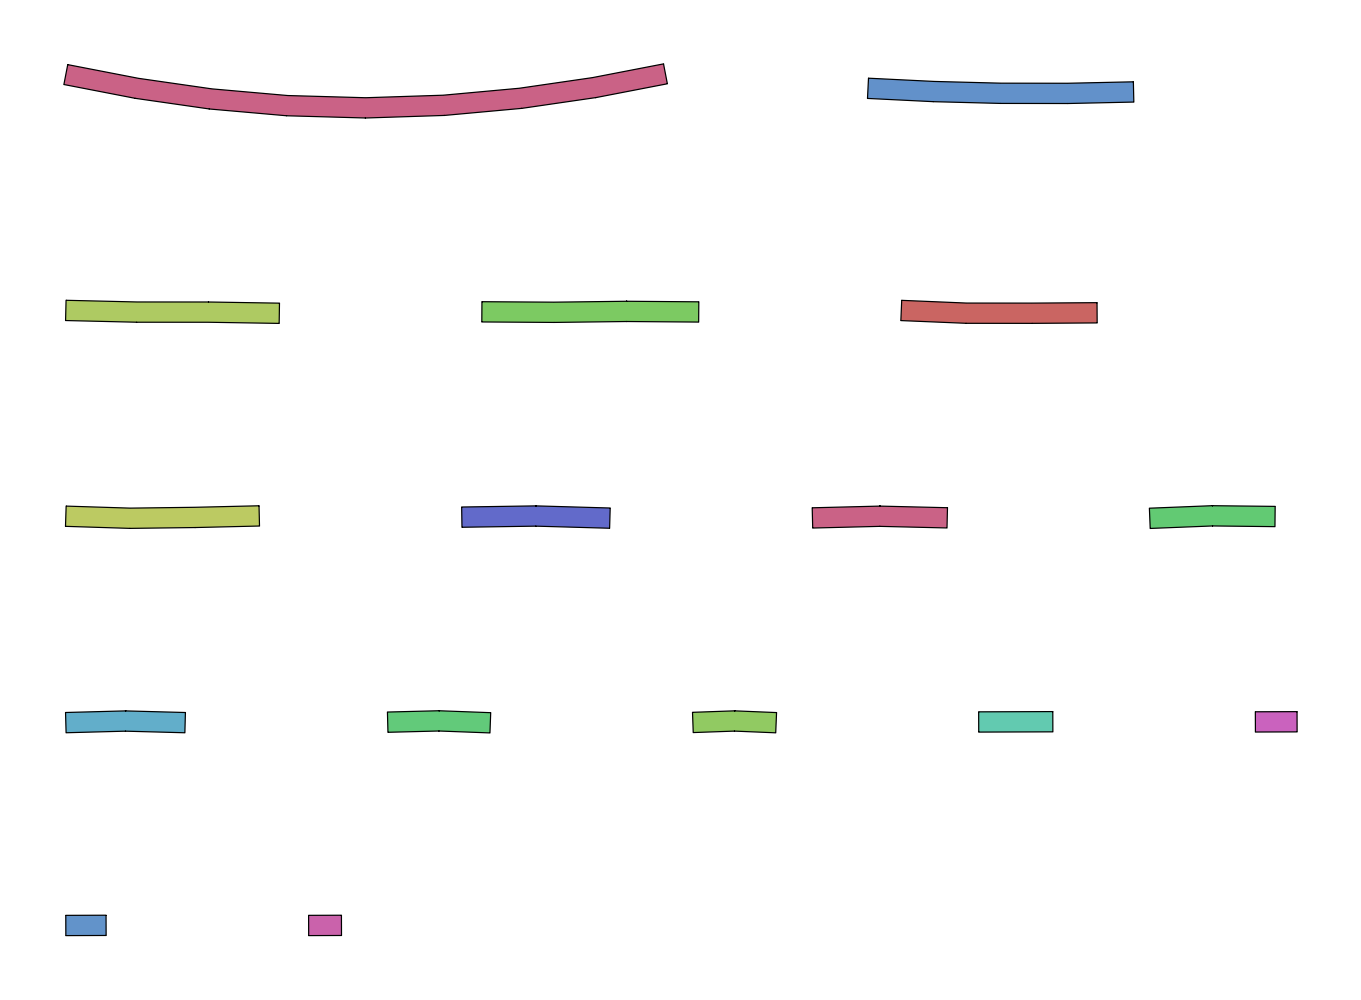

In [1]:
Bandage image dataset4/sparse.asm.bp.p_ctg.noseq.gfa dataset4/sparse.png
cat dataset4/sparse.png | display

Significantly more fragmented!

We can also look at the other GFA files.  We have been looking at primary _contig_ graphs.  A _unitig_ graph includes all connections in the assembly within reason (e.g., a certain level of read coverage and base quality of he reads). In other words these can include regions that show some degree of variation, though it may be low coverage and possibly erroneous.  These are generally cleaned up in the primary assembly if the number of haplotypes expected is less than 2 (like this case). 

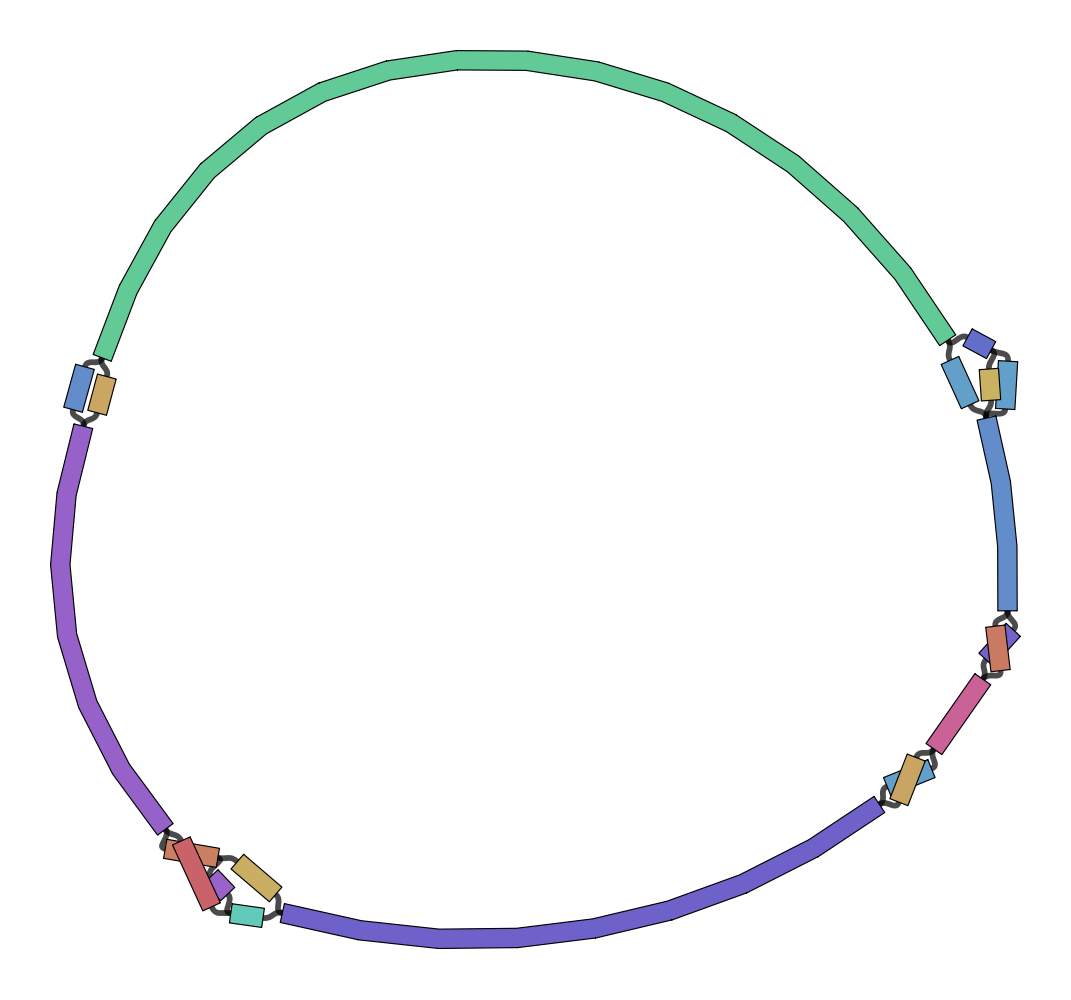

In [2]:
Bandage image dataset1/full.asm.bp.p_utg.noseq.gfa dataset1/full.unitig.png
cat dataset1/full.unitig.png | display

Here we can see there are some more complex regions even for a bacterial assembly.  Since these are removed in the primary contig assembly, the other paths were likely pruned (removed) based on poor read evidence.